# `epyc`: Python computational experiment management

[Simon Dobson](mailto:simon.dobson@computer.org) <br>
School of Computer Science, University of St Andrews UK

## Motivation

Computational experiments are becoming a lot more common: some would argue that simulation is now the "third pillar" of science, alongside theory and experiment. As computers have become more powerful, multicore machines and local compute clusters have made it more feasible to perform computational experiments from the desktop.

There are important differences between computational experiments and the "normal" process of scientific software. FIrstly, experiments need to be **reproducible** so that other scientists can check (and extend) results. Secondly, experiments need to **scale** so that larger problems can be tackled, ideally using the same code as the experiment scales up. Finally, experiments often imvolve a lot of **repetition**, which makes them **time-consuming** and difficulty to manage, especially when some calculations may fail because of transient problems with machines or networks. All these issues make writing robust computational experiments more complicated.

However, it is also true that many different computational experiments share a common computational pattern. A particularly common pattern is to perform the same computation at different points in a multi-dimensional parameter space, possibly repeating the computation many times if it is stochastic. A good example comes from network science, where we might study the effect of a parameter (such as the mean degree of the network) on the spread of an epidemic or some other process. We would perform a sequence of experiments where, for a range of mean degrees, we repeatedly create a random networkj with that mean degree and run the epidemic process, collecting some statistics about each experiment, and then aggregate all the results to draw a final graph to illustrate the effect of the parameter. This protocol might give rise to several thousand independent simulations that need to be run and their results collected. Doing this in a reasonable time might involve using a dedicated multicore machine or compute cluster, and we would like to fire-off all the calculations, leave them to run, and come back later to collect the results.

Python is now the *lingua franca* of scientific computing, and often provides excellent libraries for performing the individual experiments. But there is a need to co-ordinate these excperiments and repetitions, to make them easy to use in a modern computing environment, and to make them as reproducible as possible. This is what `epyc` seeks to do.

## Installation

To use `epyc` in a project, just install it from PyPi using `pip`:

<pre>
pip install epyc
</pre>

If you want to develop `epyc` itself, the sources are hosted on GitHub. To get the sources, simply clone the repository:

<pre>
git clone git@github.com:simoninireland/epyc.git
cd epyc
</pre>

You can then install from these sources if you wish:

<pre>
python setup.py install
</pre>

## A simple use case

Suppose you want to calculate the value of a function at various points on a 2D grid, and plot the results. (OK, there are easier ways to do this, but let's pretend...) We can see this process as a set of "experiments", where each experiment calculates the value of the function given a pair of $(x, y)$ parameters.

We need first to load `epyc`:

In [1]:
import epyc

/Users/sd/research/programming/epyc/venv/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


We will also need some extra libraries to perform calculations and plot the results:

In [2]:
import numpy
import math

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn

import pandas

/Users/sd/research/programming/epyc/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


For the sake of simplicity, we will plot a two-dimensional surface of $sin \sqrt{x^2 + y^2}$ about $(0, 0)$, extending $2 \pi$ radians in each axial direction. We first create a class describing our experiment. We do this by extending `epyc`'s `Experiment` class and overriding the `do()` method to provide the code actually executed:

In [3]:
class CurveExperiment(epyc.Experiment):
    '''An experiment that computes a sin function at points on the plane.'''
    
    def do( self, params ):
        '''Compute the sin value from two parameters x and y, returning a dict
        containing a result key.
        
        params: the parameters
        returns: the result dict'''
        x = params['x']
        y = params['y']
        r = numpy.sin(numpy.sqrt(x**2 + y**2))
        return dict(result = r)

We then set up a `epyc` laboratory to run the experiments. Since the calculation is fairly small, but we want the results to be re-usable, we create a standard `Lab` instance storing results in a notebook that uses JSON for portability:

In [4]:
lab = epyc.Lab(notebook = epyc.JSONLabNotebook("sin.json",
                                               create = True,
                                               description = "A 2D surface of $sin \sqrt{x^2 + y^2}$"))

We want to perform our experiment in two dimensions at a reasonably high resolution. We add two parameter dimensions to our lab, each one running through a range $[ -2 \pi, 2 \pi ]$:

In [5]:
lab['x'] = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi)
lab['y'] = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi)

We can then run the experiments, letting the lab execute the experiment code for each point in the parameter space:

In [6]:
lab.runExperiment(CurveExperiment())

The results are stored in the notebook underlying the lab, and we can retreive them for processing:

In [7]:
results = lab.results()

Each result is a dict containing three top-level keys: the parameters for the experiment, the resaaults of the experiment, and the metadata associated with the running of the experiment. We can examine one to see the structure:

In [8]:
results[0]

{'metadata': {'elapsed_time': 1.3000000000040757e-05,
  'end_time': 2.984245,
  'experiment_time': 1.09999999997612e-05,
  'setup_time': 1.000000000139778e-06,
  'start_time': 2.984232,
  'status': True,
  'teardown_time': 1.000000000139778e-06},
 'parameters': {'x': -1.4105109873260302, 'y': -6.2831853071795862},
 'results': {'result': 0.15574014845264431}}

Since we used a JSON notebook for this lab, the results are also saved into the file we selected above for the notebook (`sin.json`) in JSON format. This means they can be processed by any tool that understands JSON: it also means they can be re-loaded into another Python session later if required.

To plot the results we need to wrangle the results into a slightly more friendly format. The easiest approach is to convert the list of dicts into a `pandas` data frame containing all the parameters and results in a tabular form:

In [9]:
df = lab.notebook().dataframe()

(The `DataFrame` also contains the metadata values for each experiment.) We can then plot the results against the paremeters to create a surface:

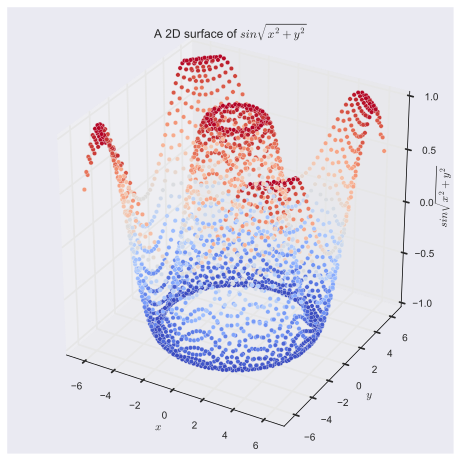

In [10]:
fig = plt.figure(figsize = (8, 8))
ax = fig.gca(projection = '3d')

ax.scatter(df['x'], df['y'], df['result'], c = df['result'], depthshade = False, cmap = cm.coolwarm)
ax.set_xlim(numpy.floor(df['x'].min()), numpy.ceil(df['x'].max()))
ax.set_ylim(numpy.floor(df['y'].min()), numpy.ceil(df['y'].max()))
ax.set_zlim(numpy.floor(df['result'].min()), numpy.ceil(df['result'].max()))

plt.title(lab.notebook().description())
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$sin \sqrt{x^2 + y^2}$')

plt.show()

This simple use case shows `epyc` structuring the execution of a set of experiments and allowing them to be recorded in a standard format. There's more to `epyc` than this, especially when it comes to high-performance computing. But first we'll describe the three main concepts in `epyc`. We'll then discuss the features that let you scale-out experiments to asynchronous compute clusters with essentially no changes to your code.   

## Concepts

`epyc` has three main concepts: experiments, lab notebooks, and labs.

### Experiments

An experiment derived from the `Experiment` class. The simplest experiment simply overrides the `do()` method, which is passed a dict mapping parameter names to values at which the experiment should be evaluated, and returns a dict of results:

In [11]:
class SumExperiment(epyc.Experiment):
    '''A simple experiment that sums its parameters.'''
    
    def do( self, params ):
        '''Sum the parameters and store the resulting sum as total.'''
        t = 0
        for p in params.keys():
            t = t + params[p]
        return dict(total = t)

In this case we're only returning a single result: we could return any number, if we had an experiment that did some more complex calculation (as they typically will). If you want to structrure the experiment a little more, you can override the `setUp()` and `tearDown()` methods to respectively set up the experiment before running and close it down afterwards. These can be useful for defining a base class for a family of different experiments.

An experiment is run by calling `runExperiment()`, passing it a dict of parameters. Running the experiment sets it up, does it, and then tears it down:

In [12]:
e = SumExperiment()
e.runExperiment(dict(a = 1, b = 10, c = 4))

{'metadata': {'elapsed_time': 1.4000000000180535e-05,
  'end_time': 4.689585,
  'experiment_time': 4.999999999810711e-06,
  'setup_time': 7.000000000090267e-06,
  'start_time': 4.689571,
  'status': True,
  'teardown_time': 2.000000000279556e-06},
 'parameters': {'a': 1, 'b': 10, 'c': 4},
 'results': {'total': 15}}

The result of an experiment is a dict with three top-level keys:

* `epyc.Experiment.PARAMETERS`: the parameters at which the experiment was evaluated
* `epyc.Experiment.RESULTS`: the results (as returned by `do()`)
* `epyc.Experiment.METADATA`: metadata associated with the experiment, mainly its run-time

The results can also be accessed using the `results()` method:

In [13]:
e.results()

{'metadata': {'elapsed_time': 1.4000000000180535e-05,
  'end_time': 4.689585,
  'experiment_time': 4.999999999810711e-06,
  'setup_time': 7.000000000090267e-06,
  'start_time': 4.689571,
  'status': True,
  'teardown_time': 2.000000000279556e-06},
 'parameters': {'a': 1, 'b': 10, 'c': 4},
 'results': {'total': 15}}

However, it's almost never necessary to actually run an experiment manually, since that's the responsibility of labs; similarly, results are the responsibility of lab notebooks.

### Lab notebooks

A lab notebook stores the results of a set of experiments conducted within a lab. Notebooks are instances of `LabNotebook`, and provide a dict-like interface but with additional structure.

The simplest notebook is an in-memory structure, which can optionally be given a free text description:

In [14]:
notebook = epyc.LabNotebook(description = "A simple notebook for demonstration purposes")

We saw a more complex notebook above when we used a JSON file to persist the notebook data to, and sub-classes of `LabNotebook` are generally used for larger experimental protocols: we describe them more below. If we want to check whether a notebook has a persistent existence &ndash; if it will survive a machine reset &ndash; then we can check the `isPersistent()` method:

In [15]:
print notebook.isPersistent()

False


The default, in-memory notebook is not persistent.

We add a result to a notebook by simply passing in the hash returned from running an experiment:

In [16]:
notebook.addResult(e.results())

The result is filed away along with the parameters at which it was executed. We can retrieve all the results as an array:

In [17]:
notebook.results()

[{'metadata': {'elapsed_time': 1.4000000000180535e-05,
   'end_time': 4.689585,
   'experiment_time': 4.999999999810711e-06,
   'setup_time': 7.000000000090267e-06,
   'start_time': 4.689571,
   'status': True,
   'teardown_time': 2.000000000279556e-06},
  'parameters': {'a': 1, 'b': 10, 'c': 4},
  'results': {'total': 15}}]

Alternatively, we can retrieve results as a `DataFrame` for use with the `pandas` data analysis package: 

In [18]:
notebook.dataframe()

,a,b,c,elapsed_time,end_time,experiment_time,setup_time,start_time,status,teardown_time,total
0,1,10,4,0.000014,4.689585,0.000005,0.000007,4.689571,True,0.000002,15


Note here that we have columns (series) for the parameters, results, and metadata for each experiment.

As well as results, notebooks can be configured to expect "pending" results. A pending result is a point in the parameter space where we *intend* to run an experiment, but for which at present we have no results. A pending result is created by providing a point and an optional identifier for the result:

In [19]:
p = dict(a = 10, b = 20, c = 30)
notebook.addPendingResult(p, 1)

The parameter space of the notebook now contains two points: the first for which we have a result, and a new one whose results are pending:

In [20]:
notebook.parameterSpaceSize()

2

The length of the notebook is the number of results it actually contains, the length of the list that `results()` returns if called:

In [21]:
len(notebook)

1

We can resolve the pending result by adding it once the result has been acquired:

In [22]:
notebook.addResult(e.runExperiment(p))

Alternatively we can cancel a pending result, either by parameter or by job identifier:

In [23]:
notebook.addPendingResult(dict(a = 1, b = 2, c = 3), 2)
notebook.addPendingResult(dict(a = 13, b = 21, c = 35), 3)
print "Before cancelling we have {p} results pending".format(p = len(notebook.pendingResults()))

print "The identifiers of the pending results are {js}".format(js = notebook.pendingResults())

notebook.cancelPendingResult(dict(a = 1, b = 2, c = 3))
print "Cancelling the first pending result leaves {p} pending results".format(p = len(notebook.pendingResults()))

notebook.cancelPendingResult(3)
print "Cancelling the second pending result by identifier leaves {p} pending results".format(p = len(notebook.pendingResults()))

Before cancelling we have 2 results pending
The identifiers of the pending results are [3, 2]
Cancelling the first pending result leaves 1 pending results
Cancelling the second pending result by identifier leaves 0 pending results


While this may seem like strange functionality to want, it is used with more complicated labs to control parallel and remote execution of experiments.

### Labs

A lab is an instance of the `Lab` class, and controls the execution of a number of experiments. A lab is given a set of named parameters, each defined by a range of values. Typically these are given by a list of explicit values, or are created by a constructor such as `numpy.linspace()` that creates a sequence of equally-spaced values across a range. A lab runs an experiment against all the points defined by the parameter space, storing the results in a notebook.

The default constructor for a lab creates an simple lab writing to an in-memory notebook:

In [24]:
simpleLab = epyc.Lab()

`Lab` exposes two interfaces for setting the parameters, either using an explicit `addParameter()` method or by indexing:

In [25]:
simpleLab.addParameter('a', [ 1, 2, 3 ])
simpleLab['b'] = numpy.linspace(0, 1, 5)

These each add a parameter and give it a range. We can retrieve both the parameter names and the ranges, again by indexing:

In [26]:
for p in simpleLab.parameters():
    print "{p} -> {r}".format(p = p, r = simpleLab[p])

a -> [1, 2, 3]
b -> [ 0.    0.25  0.5   0.75  1.  ]


The length of a lab is the total number of data points in its parameter space:

In [27]:
print "Lab will explore {n} points".format(n = len(simpleLab))

Lab will explore 15 points


The actual points to be explored can be retreieved as a list if required:

In [28]:
print simpleLab.parameterSpace()

[{'a': 1, 'b': 0.0}, {'a': 1, 'b': 0.25}, {'a': 1, 'b': 0.5}, {'a': 1, 'b': 0.75}, {'a': 1, 'b': 1.0}, {'a': 2, 'b': 0.0}, {'a': 2, 'b': 0.25}, {'a': 2, 'b': 0.5}, {'a': 2, 'b': 0.75}, {'a': 2, 'b': 1.0}, {'a': 3, 'b': 0.0}, {'a': 3, 'b': 0.25}, {'a': 3, 'b': 0.5}, {'a': 3, 'b': 0.75}, {'a': 3, 'b': 1.0}]


Each point is represented as a dict with named parameters. To run an experiment, we simply pass it to the lab's `runExperiment()`  method:

In [29]:
e = SumExperiment()
simpleLab.runExperiment(e)

Running the experiment may take some time, although not in this case. Once executed, we can check whether all the results are available:

In [30]:
simpleLab.ready()

True

We can then access the results either directly as a list or indirectly by accessing the lab's notebook:

In [31]:
print "We conducted {n} experiments".format(n = len(simpleLab.results()))
print "The notebook holds {n} results".format(n = len(simpleLab.notebook()))

We conducted 15 experiments
The notebook holds 15 results


## More sophisticated notebooks and labs

The real usefullness of `epyc`, you'll be pleased to hear, comes from more complicated situations than the ones we've just explored. The main application of `epyc` is to manage large volumes of experiments that take a long time (of the order of days or weeks) to run. Two additional features provide support for these tasks: persistent notebooks and cluster-based labs.

### JSON notebooks: persistence of results

A `JSONLabNotebook` stores its results persistently in a JSON file. The name of the notebook is the file in which the JSON structure is stored:

In [32]:
jsonNotebook = epyc.JSONLabNotebook('complex.json', create = True, description = "Something to keep")

The `create` argument, if `True`, causes the file to be emptied if it exists. By default, if the file exists, it is read back in to re-build the notebook. It is this that allows the notebook to persist across sessions:

In [33]:
r = simpleLab.notebook().result({ 'a': 1, 'b': 0.0 })
jsonNotebook.addResult(r)
jsonNotebook.commit()

otherJsonNotebook = epyc.JSONLabNotebook('complex.json', description = "Something we kept?")
print "Our description is '{d}', with {n} results".format(d = otherJsonNotebook.description(),
                                                          n = len(otherJsonNotebook))

Our description is 'Something to keep', with 1 results


(Note that we got the persistent notebook's description.) The JSON notebook persistently keeps track of results and &ndash; most importantly &ndash; pending results: the complete state of an on-going experimental protocol, co-ordinated by a lab.

Note the call to `commit()` in the code above. This ensures that the in-memory state of the notebook is persisted to disc. This can happen automatically, but explicitly commiting never hurts, and anyway the notebook is almost always managed through a lab, which handles commitment itself.

### Cluster labs: asynchronous parallel processing

A `ClusterLab` is a lab that sends experiments to an IPython compute cluster, dividing them between the available engines and collecting the results. It does this aynchronously, meaning that, once submitted, the lab itself can be disconnected and then re-connected later. It also allows results to be collected piecemeal, whihc can be useful when looking at intermediate results or results that refine towards a final goal.

We assume that you already know how to set up an IPython cluster: a detailed tutorial can be found [here](http://www.simondobson.org/complex-networks-complex-processes/complex-networks-complex-processes.html) (see [part 3](http://www.simondobson.org/complex-networks-complex-processes/part-scale.html) in particular). The cluster needs to be set up for asynchronous access, meaning that it needs a database to store messages in. Generally speaking it is enough to provide a line such as:

<pre>
c.HubFactory.db_class ="IPython.parallel.controller.sqlitedb.SQLiteDB"
</pre>

in the `ipcontroller_config.py` configuration file.

Cluster labs are created by specifying a cluster to connect to. This might be a local "default" cluster, or might be a remote cluster set up on a compute server. The local case is handy for debugging:

In [34]:
clusterLab = epyc.ClusterLab(notebook = epyc.JSONLabNotebook("cluster.json",
                                                             create = True,
                                                             description = "An asynchronous surface $sin \sqrt{x^2 + y^2}$"))

<module 'ipyparallel.serialize' from '/Users/sd/research/programming/epyc/venv/lib/python2.7/site-packages/ipyparallel/serialize/__init__.pyc'>


For the remote case, the constructor takes the same arguments as `ipyparallel.Client()`, which includes things like an IPython profile name, an SSH private keyfile for encryption and authentication, an `ipcontroller-client.json` file with connection information, and so forth:

<pre>
remoteClusterLab = epyc.ClusterLab(notebook = epyc.JSONLabNotebook("remote.json",
                                                                   create = True),
                                   url_file = 'ipcontroller-client.json',
                                   paramiko = True,
                                   sshkey = '/path/to/your/ssh/identity'))
</pre>

In any event, the result is a lab with an associated (persistent) notebook. We can run the same experiments as we used before, spread across a parameter space &ndash; although now we probably have more computing available, we can work at finer resolution if we like (although for the time being we'll actually work with *less* resolution).

In [35]:
clusterLab['x'] = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, num = 25)
clusterLab['y'] = numpy.linspace(-2 * numpy.pi, 2 * numpy.pi, num = 25)

Since `epyc` runs on top of `ipyparallal` it inherits many of this package's features. Notably we need to be sure that all the packages we need to run our experiment are imported onto the engines that make up the cluster. We can do this by using the same `sync_imports()` style as `ipyparallel` uses:

In [36]:
with clusterLab.sync_imports():
    import numpy

importing numpy on engine(s)


We don't need to worry about the code for the experiment itself, as that's passed automatically. We do however need to take care to import any packages that the experiment itself uses: `numpy` in this case.

When we run the experiment, the `runExperiment()` method submits the experiments to the cluster and returns immediately. All the experiments' results are recorded as pending in the lab's notebook. We can test what fraction of results are ready by calling `readyFraction()`, which returns a number between 0 and 1:

In [37]:
clusterLab.runExperiment(CurveExperiment())
print "Pretty soon we had {r}% of results ready".format(r = clusterLab.readyFraction() * 100)

Pretty soon we had 95.84% of results ready


Unsurprisingly, we didn't get all the results immediately. But if we run the method again, we may find that things have changed:

In [38]:
print "Then we had {r}% of results ready".format(r = clusterLab.readyFraction() * 100)

Then we had 100.0% of results ready


We can then retrieve and plot them as before:

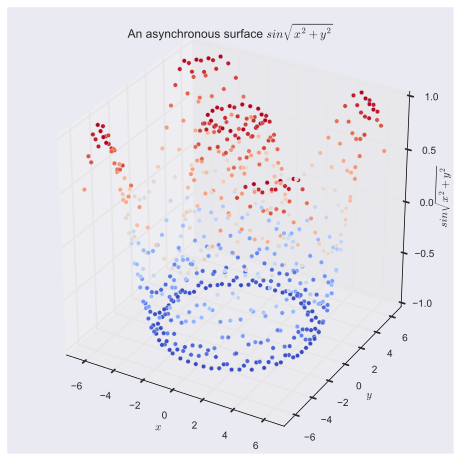

In [39]:
df = clusterLab.notebook().dataframe()

fig = plt.figure(figsize = (8, 8))
ax = fig.gca(projection = '3d')

ax.scatter(df['x'], df['y'], df['result'], c = df['result'], depthshade = False, cmap = cm.coolwarm)
ax.set_xlim(numpy.floor(df['x'].min()), numpy.ceil(df['x'].max()))
ax.set_ylim(numpy.floor(df['y'].min()), numpy.ceil(df['y'].max()))
ax.set_zlim(numpy.floor(df['result'].min()), numpy.ceil(df['result'].max()))

plt.title(clusterLab.notebook().description())
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$sin \sqrt{x^2 + y^2}$')

plt.show()

## More sophisticated experiments: replication

Many computational experiments include a stochastic element, whereby the result of the experiment is conditioned, but not completely determined, by its parameters. An example is epidemic spreading on a network, which depends on parameters describing the network topology and process infectivity &ndash; but also on the adjacency matrix of the network and on the exact locations of the initially infected nodes, which are both typically determined randomly.

To get robust results from these situations, a researcher typically performs multiple repetitions of the same experiment at the same point in its parameter space, and then studies the summary statistics. Using epidemic spreading as an example again, one might sweep the parameter describing infectivity through a range of values, and at each value create a random network and see whether the epidemic spreads &ndash; and perform 1000 repetitions of this for each infectivity value. The result of this would be, for each infectivity a mean epidemic size and its variance &ndash; and the latter will have been reduced by the repetions.

One can build this functionality by hand, but it's so common that it makes more sense to encapsulate it as an experiment combinator: an experiment that takes another, *underlying* experiment and repeats and summarises it.

The `RepeatedExperiment` class provides this function. To illustrate it, let's define another experiment that [estimates the value of $\pi$ using Monte Carlo simulation](https://curiosity-driven.org/pi-approximation). [TO BE COMPLETED]

In [41]:
class PiExperiment(epyc.Experiment):
    '''Compute $\pi$ by Monte Carlo simulation'''
    
    def do( self, params ):
        '''Use n points to estimate pi, returning the number of points landing
        in the circle (as ncirc) and the estimate of pi (as pi).
        
        params: the parameters
        returns: a result dict'''
        N = params['n']
        
        # perform N random observations
        inCircle = 0
        for i in xrange(N):
            # generate a random point
            [x, y] = numpy.random.random(2)
            
            # check whether point lies within a distance 1 to the top-left
            if math.sqrt(math.pow(x, 2) + math.pow(y, 2)) <= 1.0:
                # yes, increment the counter
                inCircle = inCircle + 1
                
        # compute pi and return
        incirc = (inCircle + 0.0) / N
        return dict(incirc = incirc, pi = 4.0 * incirc)

We can run this experiment to get estimates of $\pi$ for different numbers of random sample points, and then study how the process converges to the real value of $\pi$. A single run generates a single estimate:

In [42]:
e = PiExperiment()
e.runExperiment(dict(n = 10))

{'metadata': {'elapsed_time': 0.00043699999999979866,
  'end_time': 11.364344,
  'experiment_time': 0.00042600000000092564,
  'setup_time': 7.000000000090267e-06,
  'start_time': 11.363907,
  'status': True,
  'teardown_time': 3.999999998782755e-06},
 'parameters': {'n': 10},
 'results': {'incirc': 0.8, 'pi': 3.2}}

The `results` section holds the estimate under the key `pi`. It isn't a good estimate, but then we only used 10 sample points: more points should generate better estimates. We also record that only a fraction `incirc` of the sample points landed in the circle. However, the process is stochastic as the sample points are chosen randomly, so different runs of the experiment may generate different estimates:

In [45]:
# run five repetitions and show the different results
pis = []
for i in xrange(5):
    res = e.runExperiment(dict(n = 10))
    pis.append(res[epyc.Experiment.RESULTS]['pi'])
print pis

[3.2, 2.8, 3.6, 3.6, 2.8]


It would therefore make more sense to perform several repetitions of the experiment for the same number of sample points, take the mean of the repetitions as the estimate, and plot this alongside the variance to show how the process converges. We can do the calculation by wrapping-up the `PiExperiment` within a `RepeatedExperiment`: 

In [46]:
# create a lab with a parameter n for sample points
lab = epyc.Lab()
lab['n'] = xrange(1, 5000, 10)

# create an experiment performing 100 repetitions at each point
N = 100
er = epyc.RepeatedExperiment(e, N)

# run the experimental protocol
lab.runExperiment(er)

This is quite a lot of computation from a small amount of code: 100 repetitions at each of 500 different values of $n$, 50000 runs of the experiment in all. Let's look at one of the results:

In [47]:
lab.results()[0]

{'metadata': {'elapsed_time': 2.0504929999999604,
  'end_time': 522.520626,
  'experiment_time': 2.0504889999999705,
  'repetitions': 100,
  'requested_repetitions': 100,
  'setup_time': 9.999999974752427e-07,
  'start_time': 520.470133,
  'status': True,
  'teardown_time': 2.999999992425728e-06,
  'underlying_elapsed_time_mean': 0.020803000000000793,
  'underlying_elapsed_time_variance': 0.0},
 'parameters': {'n': 451},
 'results': {'incirc_mean': 0.78538802660753892,
  'incirc_median': 0.78713968957871394,
  'incirc_variance': 0.00030730379889971053,
  'pi_mean': 3.1415521064301557,
  'pi_median': 3.1485587583148558,
  'pi_variance': 0.0049168607823953684}}

If we compare this to the results of the single experiment, we can see some differences. Looking at the `results` section, instead of the two results returned by the underlying `PiExperiment` &ndash; an estimate of $\pi$ and the proportion of samples in the circle, under the keys `pi` anmd `incirc` respectively &ndash; we have six values: `pi_mean`, `pi_median`, and `pi_variance` whose meanings are hopefully obvious, and likewise for `incirc`.

The `parameters` section holds the number of sample points we used to get this estimate, which weas the only parameter to the experiment.

Looking in the `metadata` section we can see values `requested_repetitions` and `repetitions` capturing the number of repetitions we asked the `RepeatedExperiment` to do and the number it successfully did. (These are the same in this case: they will differ if some repetitions failed for some reason.) This means that failed experiments aren't included in the summary statistics. You can also see values like `underlying_elapsed_time_mean` that summarise the behaviour of the underlying experiment, while the values like `elapsed_time` refer to the `RepeatedExperiment` itself.

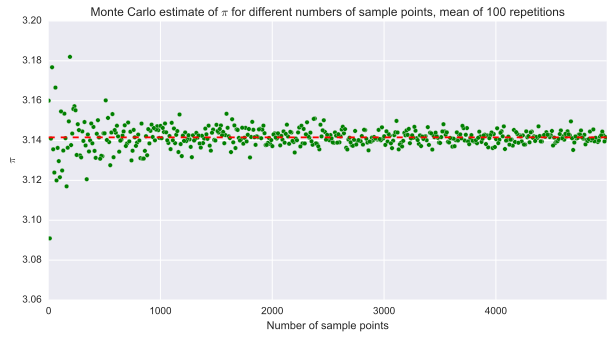

In [48]:
df = lab.notebook().dataframe()

fig = plt.figure(figsize = (10, 5))
ax = fig.gca()
(lx, hx) = (numpy.floor(df['n'].min()), numpy.ceil(df['n'].max()))

# scatter plot of the estimates
ax.scatter(df['n'], df['pi_mean'], c = 'g')
ax.set_xlim(lx, hx)

# "real" value
ax.plot([lx, hx], [math.pi, math.pi], 'r--')

ax.set_title('Monte Carlo estimate of $\pi$ for different numbers of sample points, mean of {rep} repetitions'.format(rep = N))
ax.set_xlabel('Number of sample points')
ax.set_ylabel('$\pi$')
plt.show()

Once can generate the same plot by different means, of course, for example by performing all the repetitions as separate experiments (giving the lab a new element to its parameter space), or by making the individual experiment perform repetitions and averaging. But the `RepeatedExperiment` makes it simple to perform one of the most common experimental protocols.

One extra advantage of separating the underlying experiment from its summarisation is that you can change the results you collect. If, for example, you're only intertested in a sub-set of the values that each experiment returns, you can instruct the `RepeatedExperiment` to only generate summary statistics for particular values. If since we don't use the `incirc` value that `PiExperiment` returns, we could discard it by instructing our `RepeatedExperiment` to only summarise the `pi` estimate:

In [50]:
er = epyc.RepeatedExperiment(e, N, summarised_results = [ 'pi' ])

A similar keyword, `summarised_metadata`, controls the metadata values from the underlying experiment that are returned. Setting this to `[]` will drop all the timing metadata. These optimisations don't in general save a lot of time, but they result in smaller datasets and simpler `DataFrame`s that can be easier to understand for complicated experiments. In any case, they allow for more flexible re-use of experimental code.